
## Subjective/Objective Sentence Classifier
#### Spencer Ball, November 2020

In [ ]:
# Importing useful libraries/packages

import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchtext
from torchtext import data
import spacy

import numpy as np
import matplotlib.pyplot as plt

import os
from time import time

!python -m spacy download en        # this command installs the SpaCy english library 

In [ ]:
# Change hyperparameters here

batch_size = 64
lr = 0.001
epochs = 25
model_type = 1        # == 1 --> use Baseline model; == 2 --> use CNN model; == 3 --> use RNN model
overfit_toggle = 0    # == 0 use train_data.tsv for training; == 1 use overfit.tsv for training

# CNN settings
embedding_dim = 100
filter_sizes = [2,4]
n_filters = 50

# RNN settings
rnn_hidden_dim = 100

# Random generator settings
rseed = 3
torch.manual_seed(rseed)    # setting random seed

loss_func = nn.BCEWithLogitsLoss()

In [ ]:
# Importing data

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ECE324/a5/data.tsv', sep='\t')   # data is [10000 rows x 2 columns]


# splitting set into objective and subjective data (ensuring equal class representation)
data_obj = data[data["label"] == 0]
data_sub = data[data["label"] == 1]

# splitting dataset into train (64%), validation (16%), and test (20%) sets
train_data_obj,test_data_obj = train_test_split(data_obj,test_size=0.36,random_state=1)
test_data_obj,valid_data_obj = train_test_split(test_data_obj,test_size=0.4444,random_state=1)

train_data_sub,test_data_sub = train_test_split(data_sub,test_size=0.36,random_state=1)
test_data_sub,valid_data_sub = train_test_split(test_data_sub,test_size=0.4444,random_state=1)

# concatenating obj & subj sets back together
train_sets = [train_data_obj, train_data_sub]
test_sets = [test_data_obj, test_data_sub]
valid_sets = [valid_data_obj, valid_data_sub]

train_data = pd.concat(train_sets)
test_data = pd.concat(test_sets)
valid_data = pd.concat(valid_sets)

# Taking 50 random samples to test for overfitting (use same procedure as above)
unused_data,overfit_obj = train_test_split(data_obj,test_size=0.005,random_state=3)
unused_data,overfit_sub = train_test_split(data_sub,test_size=0.005,random_state=3) 

overfit_sets = [overfit_obj, overfit_sub]
overfit = pd.concat(overfit_sets)


# Writing to new TSV files
train_data.to_csv('/content/drive/My Drive/Colab Notebooks/ECE324/a5/train_data.tsv', sep='\t',index=False)
valid_data.to_csv('/content/drive/My Drive/Colab Notebooks/ECE324/a5/valid_data.tsv', sep='\t',index=False)
test_data.to_csv('/content/drive/My Drive/Colab Notebooks/ECE324/a5/test_data.tsv', sep='\t',index=False)
overfit.to_csv('/content/drive/My Drive/Colab Notebooks/ECE324/a5/overfit.tsv', sep='\t',index=False)


# printing the number of objective & subjective sentences in each set (for project document)

print('training set, objective:', train_data_obj.shape)
print('training set, subjective:', train_data_sub.shape)

print('validation set, objective:', valid_data_obj.shape)
print('validation set, subjective:', valid_data_sub.shape)

print('test set, objective:', test_data_obj.shape)
print('test set, subjective:', test_data_sub.shape)

print('overfit set, objective:', overfit_obj.shape)
print('overfit set, subjective:', overfit_sub.shape)

In [ ]:
# Three model architectures (baseline, cnn, rnn)

class Baseline(nn.Module):

    def __init__(self, embedding_dim, vocab):
        super(Baseline, self).__init__()

        self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
        self.fc = nn.Linear(embedding_dim, 1)

    def forward(self, x, lengths=None):
        #x has shape [sentence length, batch size]
        embedded = self.embedding(x)

        average = embedded.mean(0) # [sentence length, batch size, embedding_dim]
        output = torch.sigmoid(self.fc(average).squeeze(1))

	      # Note - using the BCEWithLogitsLoss loss function
        # performs the sigmoid function *as well* as
        # the binary cross entropy loss computation
        # (these are combined for numerical stability)

        return output


class CNN(nn.Module):

    def __init__(self, embedding_dim, vocab, n_filters, filter_sizes):
        super(CNN, self).__init__()

        self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
        self.conv1 = nn.Conv2d(1,n_filters,kernel_size=(filter_sizes[0],embedding_dim))
        self.conv2 = nn.Conv2d(1,n_filters,kernel_size=(filter_sizes[1],embedding_dim))
        self.fc = nn.Linear(embedding_dim,1)

    def forward(self, x, lengths=None):
        embedded = self.embedding(x)
        embedded = torch.transpose(embedded,0,1).unsqueeze(1)
        x1 = F.relu(self.conv1(embedded))
        x2 = F.relu(self.conv2(embedded))
        x1, unused1 = torch.max(x1, 2)
        x2, unused2 = torch.max(x2, 2)
        x1 = x1.squeeze(2)
        x2 = x2.squeeze(2)
        x = torch.stack((x1,x2),2)
        if (x.shape[0] != batch_size):
            x = torch.reshape(x,(x.shape[0],100))
        else:
            x = torch.reshape(x,(batch_size,100))

        output = torch.sigmoid(self.fc(x).squeeze(1))

        return output
        

class RNN(nn.Module):

    def __init__(self, embedding_dim, vocab, hidden_dim):
        super(RNN, self).__init__()

        self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_dim)
        self.fc = nn.Linear(embedding_dim,1)  # fully connected linear layer

    def forward(self, x, lengths=None, batch_size=None):
        embedded = self.embedding(x)
        embedded = torch.transpose(embedded,0,1)  # correct the dimensions for GRU compatibility
        x = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True) # pads the embedded-form sentences with zeros so they all contain same # of words
        x_unpack, len_unpack = nn.utils.rnn.pad_packed_sequence(x, batch_first=True) # len_unpack unused here
        x, states = self.gru(x_unpack)  # put padded sentences into GRU (entire batch)
        x = torch.transpose(x,0,1) ]    
        average = x.mean(0)
        output = self.fc(average).squeeze(1)  # put average through the linear layer to calculate output
        output = torch.sigmoid(output)        # convert output to probability-like number
        return output

In [ ]:
# =============== Functions used in training ====================


def accuracy(outputs, labels):
    
    correct = 0

    for i in range(len(outputs)):
        if (outputs[i] >= 0.5) and (labels[i] == 1):
            correct = correct + 1 
        if (outputs[i] < 0.5) and (labels[i] == 0):
            correct = correct + 1
    
    return (correct/len(outputs))


def validate(model, val_iter):
    
    running_loss = 0.0
    miniValAcc = []

    for i, batch in enumerate(val_iter, 0):
        
        batch_input, batch_input_length = batch.text 
        batch_label = batch.label

        # forward step
        if (model_type == 1) or (model_type == 2):
            outputs = model(batch_input)
        else:
            outputs = model(batch_input,batch_input_length)
        
        loss = loss_func(outputs.squeeze(), target=batch_label.float()) 

        running_loss += loss.item()
        miniValAcc.append(accuracy(outputs,batch_label))

    mini_val_loss = running_loss/len(miniValAcc)
    mini_val_acc = sum(miniValAcc) / len(miniValAcc)

    return mini_val_acc,mini_val_loss


def testing(model, test_iter):                # calculates and returns average test accuracy

    running_loss = 0.0
    miniTestAcc = []

    for i, batch in enumerate(test_iter, 0):
        
        batch_input, batch_input_length = batch.text 
        batch_label = batch.label

        # forward step
        if (model_type == 1) or (model_type == 2):
            outputs = model(batch_input)
        else:
            outputs = model(batch_input,batch_input_length)
        
        loss = loss_func(outputs.squeeze(), target=batch_label.float()) 

        running_loss += loss.item()
        miniTestAcc.append(accuracy(outputs,batch_label))

    test_loss = running_loss/len(miniTestAcc)
    test_acc = sum(miniTestAcc) / len(miniTestAcc)

    return test_acc,test_loss
   

Shape of Vocab: torch.Size([21105, 100])


Epoch: 1
Training accuracy: 0.50015625
Validation accuracy: 0.5
Training Loss: 0.7079078179597854
Validation Loss: 0.6890186095237731


Epoch: 2
Training accuracy: 0.5
Validation accuracy: 0.5
Training Loss: 0.6947729533910751
Validation Loss: 0.6868424916267395


Epoch: 3
Training accuracy: 0.5
Validation accuracy: 0.5
Training Loss: 0.6903859519958496
Validation Loss: 0.6859387731552125


Epoch: 4
Training accuracy: 0.5
Validation accuracy: 0.5
Training Loss: 0.687074670791626
Validation Loss: 0.6841355538368226


Epoch: 5
Training accuracy: 0.5
Validation accuracy: 0.5
Training Loss: 0.6842062067985535
Validation Loss: 0.6803130793571472


Epoch: 6
Training accuracy: 0.5
Validation accuracy: 0.5
Training Loss: 0.6809901601076126
Validation Loss: 0.6741390609741211


Epoch: 7
Training accuracy: 0.5003125
Validation accuracy: 0.5025
Training Loss: 0.6775017631053925
Validation Loss: 0.6647199606895446


Epoch: 8
Training accuracy: 0.50671875


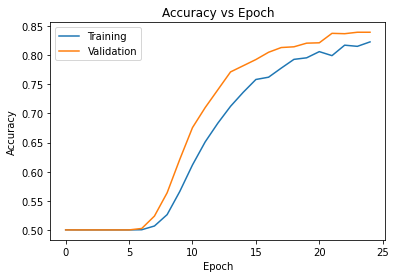

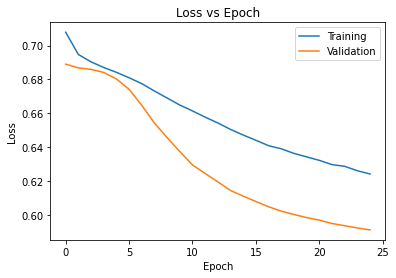

In [ ]:
def main():


    # 3.2.1
    TEXT = data.Field(sequential=True,lower=True, tokenize='spacy', include_lengths=True)
    LABELS = data.Field(sequential=False, use_vocab=False)


    if (overfit_toggle == 0):     # uses train_data.tsv as train_data

        # 3.2.2
        train_data, val_data, test_data = data.TabularDataset.splits(
                path='/content/drive/My Drive/Colab Notebooks/ECE324/a5', train='train_data.tsv',
                validation='valid_data.tsv', test='test_data.tsv', format='tsv',
                skip_header=True, fields=[('text', TEXT), ('label', LABELS)])
        
        
    if (overfit_toggle == 1):       # uses overfit.tsv as train_data

        # 3.2.2
        train_data, val_data, test_data = data.TabularDataset.splits(
                path='/content/drive/My Drive/Colab Notebooks/ECE324/a5', train='overfit.tsv',
                validation='valid_data.tsv', test='test_data.tsv', format='tsv',
                skip_header=True, fields=[('text', TEXT), ('label', LABELS)])
          

    # 3.2.3
  
    train_iter, val_iter, test_iter = data.Iterator.splits(
      (train_data, val_data, test_data), batch_sizes=(batch_size, batch_size, batch_size),
  sort_key=lambda x: len(x.text), device=None, sort_within_batch=True, repeat=False)


    # 3.2.4
    TEXT.build_vocab(train_data, val_data, test_data)
  

    # 4.1
    TEXT.vocab.load_vectors(torchtext.vocab.GloVe(name='6B', dim=100))
    vocab = TEXT.vocab

    print("Shape of Vocab:",TEXT.vocab.vectors.shape)



    # ========= 5 Training and Evaluation ===========

    # setting random seed
    torch.manual_seed(rseed)

    # instantiate model
    if (model_type == 1):
        model = Baseline(embedding_dim, vocab)
    if (model_type == 2):
        model = CNN(embedding_dim, vocab, n_filters, filter_sizes)
    if (model_type == 3):
        model = RNN(embedding_dim, vocab, rnn_hidden_dim)

    # instantiate optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # places to store values for plotting   
    nRec = 0
    trainAccRec = []
    valAccRec = [] 
    mini_train_acc = []
    trainLossRec = []
    valLossRec = []
    t = []

    # record start time of training
    tic = time()


    # training loop

    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, batch in enumerate(train_iter, 0):

            batch_input, batch_input_length = batch.text 
            batch_label = batch.label
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if (model_type == 1) or (model_type == 2):    # if model is Baseline or CNN
                outputs = model(batch_input)
            else:
                outputs = model(batch_input,batch_input_length,batch_size)    # if model is RNN
           
            loss = loss_func(outputs.squeeze(), target=batch_label.float()) 

            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            mini_train_acc.append(accuracy(outputs,batch_label))

        
        mini_val_acc, mini_val_loss = validate(model,val_iter)
        valAccRec.append(mini_val_acc)
        valLossRec.append(mini_val_loss)
        epochTrainAcc = sum(mini_train_acc) / len(mini_train_acc)
        trainAccRec.append(epochTrainAcc)
        trainLossRec.append(running_loss/len(mini_train_acc))
        t.append(time()-tic)

        print("\n")  
        print("Epoch:",epoch+1)
        print("Training accuracy:",trainAccRec[epoch])
        print("Validation accuracy:",valAccRec[epoch])
        print("Training Loss:",trainLossRec[epoch])
        print("Validation Loss:",valLossRec[epoch])

        mini_train_acc = []
        running_loss = 0.0

    toc = time()       
    print('Finished Training')


    # Plotting for the boys

    domain = np.arange(epochs)

    fig, accPlt = plt.subplots()                                 # Create a figure and an axes.\n",
    accPlt.plot(domain, trainAccRec, label='Training')           # Plot some data on the axes.\n",
    accPlt.plot(domain, valAccRec, label='Validation')         # Plot more data on the axes...\n",
    accPlt.set_xlabel('Epoch')                               # Add an x-label to the axes.\n",
    accPlt.set_ylabel('Accuracy')                                # Add a y-label to the axes.\n",
    accPlt.set_title("Accuracy vs Epoch")                    # Add a title to the axes.\n",
    accPlt.legend() 

    fig, lossPlt = plt.subplots()                                 # Create a figure and an axes.\n",
    lossPlt.plot(domain, trainLossRec, label='Training')           # Plot some data on the axes.\n",
    lossPlt.plot(domain, valLossRec, label='Validation')         # Plot more data on the axes...\n",
    lossPlt.set_xlabel('Epoch')                               # Add an x-label to the axes.\n",
    lossPlt.set_ylabel('Loss')                                # Add a y-label to the axes.\n",
    lossPlt.set_title("Loss vs Epoch")                    # Add a title to the axes.\n",
    lossPlt.legend() 

    print('Total training time =',toc-tic)

    # getting highest validation accuracy
    maxAcc = 0
    for val in valAccRec:
        if (val > maxAcc):
            maxAcc = val
    print('Highest Validation Accuracy:',maxAcc)

    # calculating average test accuracy to check for overfitting
    test_acc,test_loss = testing(model,test_iter)
    print('Test Accuracy:',test_acc)
    print('Test Loss:',test_loss)

    #torch.save(model,'model_cnn.pt')



main()

# 7. Testing on Your Own Sentence


In [ ]:
# Obtaining the Vocab object

TEXT = data.Field(sequential=True,lower=True, tokenize='spacy', include_lengths=True)
LABELS = data.Field(sequential=False, use_vocab=False)

train_data, val_data, test_data = data.TabularDataset.splits(
        path='/content/drive/My Drive/Colab Notebooks/ECE324/a5', train='train_data.tsv',
        validation='valid_data.tsv', test='test_data.tsv', format='tsv',
        skip_header=True, fields=[('text', TEXT), ('label', LABELS)])

TEXT.build_vocab(train_data, val_data, test_data)

TEXT.vocab.load_vectors(torchtext.vocab.GloVe(name='6B', dim=100))
vocab = TEXT.vocab

.vector_cache/glove.6B.zip: 862MB [06:30, 2.21MB/s]                          
100%|█████████▉| 398587/400000 [00:18<00:00, 21743.08it/s]

In [ ]:
# Function for changing string of text into tokens

def tokenizer(text):
    spacy_en = spacy.load('en')
    return [tok.text for tok in spacy_en(text)]

In [ ]:
# ========== subjective_bot ========== 
# provides custom sentence classification as directed by user


# Loading saved models
model_baseline = torch.load('model_baseline.pt')
model_cnn = torch.load('model_cnn.pt')
model_rnn = torch.load('model_rnn.pt')

again = True
while again == True:                                       # infinite prompting ended by user entering -1
    print('Enter a sentence \n')
    sentence = input()
    if sentence == '-1':
        again = False
        break

    tokens = tokenizer(sentence)                           # convert sentence to tokens
    token_ints = [vocab.stoi[tok] for tok in tokens]       # convert each string token to an integer
    token_tensor = torch.LongTensor(token_ints).view(-1,1) # convert integer tokens to torch LongTensors (shape is [sentence_len, 1])

    lengths = torch.Tensor([len(token_ints)])              # used when calling RNN model

    base_pred = model_baseline(token_tensor)
    cnn_pred = model_cnn(token_tensor)
    rnn_pred = model_rnn(token_tensor,lengths)

    base_pred = base_pred.detach().numpy()[0]
    base_class = 'subjective' if base_pred > 0.5 else 'objective'

    cnn_pred = cnn_pred.detach().numpy()[0]
    cnn_class = 'subjective' if cnn_pred > 0.5 else 'objective'

    rnn_pred = rnn_pred.detach().numpy()[0]
    rnn_class = 'subjective' if rnn_pred > 0.5 else 'objective'


    print(f"Model baseline: {base_class}", '({:.3f})'.format(round(base_pred, 3)))
    print(f"Model CNN: {cnn_class}", '({:.3f})'.format(round(cnn_pred, 3)))
    print(f"Model RNN: {rnn_class}", '({:.3f})'.format(round(rnn_pred, 3)))



Enter a sentence 

The sun rises every day.
Model baseline: objective (0.254)
Model CNN: objective (0.006)
Model RNN: objective (0.003)
Enter a sentence 

That car is cool.
Model baseline: subjective (0.789)
Model CNN: subjective (0.964)
Model RNN: subjective (0.539)
Enter a sentence 

Life is hard.
Model baseline: subjective (0.865)
Model CNN: objective (0.124)
Model RNN: objective (0.115)
Enter a sentence 

I love that car.
Model baseline: objective (0.214)
Model CNN: objective (0.005)
Model RNN: objective (0.001)
Enter a sentence 

I like that car.
Model baseline: objective (0.496)
Model CNN: objective (0.166)
Model RNN: subjective (0.552)
Enter a sentence 

That car looks cool.
Model baseline: subjective (0.936)
Model CNN: subjective (1.000)
Model RNN: subjective (0.999)
Enter a sentence 

It is hot outside today.
Model baseline: subjective (0.543)
Model CNN: objective (0.001)
Model RNN: objective (0.014)
Enter a sentence 

Today it is hot outside.
Model baseline: subjective (0.675